# **Catégoriser automatiquement des questions**
Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags afin de retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateurs de Stack Overflow, qui nous a souvent sauvé la mise, nous décidons d'aider la communauté en retour. Pour cela, nous allons développer un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

Stack Overflow propose un outil d’export de données, ["StackExchange Data Explorer"](https://data.stackexchange.com/stackoverflow/query/new), qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

# **Sommaire**

*   **Partie 1:** <a href="#C1">Importation des données</a>
*   **Partie 2:** <a href="#C2">Préparation du dataset</a>
*   **Partie 3:** <a href="#C3">Modélisation non supervisée de sujets</a>
    * <a href="#C4">LDA</a>
*   **Partie 4:** <a href="#C5">Classification supervisée des tags</a>
    * <a href="#C6">Direct Matching</a>
    * <a href="#C7">Naïve Bayes</a>
    * <a href="#C8">Arbre de Décision</a>
    * <a href="#C9">Forêt aléatoire</a>
    * <a href="#C10">Régression logistique</a>
    * <a href="#C11">Choix du modèle</a>
*   **Partie 5:** <a href="#C12">Classification supervisée avec méthodes d'embedding</a>
    * <a href="#C13">Doc2Vec</a>
    * <a href="#C14">Bert</a>
    * <a href="#C15">Use</a>
    * <a href="#C16">Résultats</a>
*   **Partie 6:** <a href="#C17">Conclusion</a>

# <a name="C1">Partie 1: Importation du jeu de données</a>
Commençons par importer les librairies ainsi que le jeu de données nettoyé.

In [ ]:
pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 4.2 MB 42.6 MB/s 
     |████████████████████████████████| 1.2 MB 57.1 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 26.9 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=11a54db4fef1394dd74758d5a699ebb454c715f2dc884ce7713e3003d9aad9fa
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 381 kB/s 
     |████████████████████████████████| 62 kB 795 kB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 146 kB 61.2 MB/s 
     |████████████████████████████████| 181 kB 48.6 MB/s 
     |████████████████████████████████| 210 kB 47.9 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112631 sha256=3d947ea2b5b852807c98952d2a16cc32e6278eb3e41ea8e6ad22e5a9b3f33a26
  Stored in directory: /root/.cache/pip/wheels/96/c1/f8/d75a22e789ab6a4dff11f18338c3af4360189aa371295cc934
Successfully built databricks-cli


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import math
import time
import timeit
import pickle
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)


from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import defaultdict
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV, cross_val_predict
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.classify import NaiveBayesClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, jaccard_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from joblib import dump, load
from mlflow.models.signature import infer_signature
import mlflow.sklearn


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

pd.set_option('display.max_columns', 100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


On peut à présent charger le jeu de données ainsi que les jeux d'entraînement et de test.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/data_clean.csv', sep=',',encoding='utf-8')
data.head()

,Unnamed: 0,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,title_bow_lem,body_bow_lem
0,0,Best way to sign data in web form with user ce...,We have a C# web app where users will connect ...,c# javascript asp.net-mvc browser x509certific...,3047437,9,6323,6,4,best sign data form user certificate,user connect using digital certificate stored ...
1,1,Google Test Fixtures,I'm trying to understand how the Google Test F...,c++ unit-testing testing googletest test-fixture,3549540,22,45601,8,2,google test fixture,trying understand google test fixture work fol...
2,2,Autocomplete Textbox results based from SQL da...,I'm trying to create an auto-complete function...,php jquery html mysql autocompletebox,21298169,6,43604,5,5,autocomplete textbox result based database,trying create auto complete function textbox r...
3,3,What are the Steps to getting a Long Lasting T...,I have a Business Page in Facebook (known as a...,facebook facebook-graph-api facebook-access-to...,18261813,15,13929,10,2,what step getting long lasting token posting f...,business page facebook known page facebook ver...
4,4,disk usage issue with rsync and --link-dest,I have disk usage problem with rsync and --lin...,linux bash shell backup rsync,21298179,9,9030,4,3,disk usage issue rsync link dest,disk usage problem rsync link dest incremental...


In [ ]:
#Jeux d'entraînement et de test avec les titres
X_train_titles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/X_train_titles.csv', sep=',',encoding='utf-8')
X_test_titles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/X_test_titles.csv', sep=',',encoding='utf-8')
y_train_titles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/y_train_titles.csv', sep=',',encoding='utf-8')
y_test_titles = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/y_test_titles.csv', sep=',',encoding='utf-8')

#Jeux d'entraînement et de test avec les questions
X_train_questions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/X_train_questions.csv', sep=',',encoding='utf-8')
X_test_questions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/X_test_questions.csv', sep=',',encoding='utf-8')
y_train_questions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/y_train_questions.csv', sep=',',encoding='utf-8')
y_test_questions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P5_BOURBON_Vicente/y_test_questions.csv', sep=',',encoding='utf-8')

In [ ]:
X_train_titles.fillna('nan', inplace=True)
X_test_titles.fillna('nan', inplace=True)

In [ ]:
l = [X_train_titles, X_test_titles, y_train_titles, y_test_titles, X_train_questions, X_test_questions, y_train_questions, y_test_questions]

for df in l:
  df.drop(['Unnamed: 0'], axis=1, inplace=True)

# <a name="C2">Partie 2: Préparation du dataset</a>
Les modèles de machine learning ne prenant en entrée que des données numériques, il nous faudra transformer nos donées en utilisant des méthodes de **bag of words** ou de **sentence embedding**. Ecrivons les fonctions nécessaires.

In [ ]:
def prepare_count_data(train_data, test_data, variable, max_number_of_features=100):
    """Fonction qui prend en entrée un jeu d'entraînement, un jeu de test et la variable à transformer, 
    et retourne les jeux transformés en bag of words"""
   
    count_vect = CountVectorizer(max_df=0.95, min_df=1, max_features=max_number_of_features)
    
    #Fit sur le jeu d'entrainement
    train_data_count = count_vect.fit_transform(train_data[variable])
    
    #Tranform sur le jeu test pour éviter la fuite d'information
    test_data_count  = count_vect.transform(test_data[variable])
    
    #On récupère le nom des features
    tokens = count_vect.get_feature_names_out()   
    
    #Création des dataframes à retourner
    train_data_count_out = pd.DataFrame(train_data_count.toarray())
    train_data_count_out.columns = tokens
    
    test_data_count_out = pd.DataFrame(test_data_count.toarray())
    test_data_count_out.columns = tokens
    
    return count_vect, train_data_count_out, test_data_count_out


def prepare_d2v_data(train_data, test_data, variable):
  """Fonction qui prend en entrée un jeu d'entraînement, un jeu de test et la variable à transformer, 
  et retourne les jeux transformés en sentence embedding via doc2vec"""

  #Préparation du corpus
  tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_data[variable])]

  #Construction du modèle
  model = Doc2Vec(vector_size=50, min_count=5, epochs=10, dm=1)

  #Construction du vocabulaire
  model.build_vocab(tagged_data)

  #Entraîenemnt du modèle sur le corpus
  model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

  #Encodage des jeux d'entraînement et de test et mise en forme en dataframe
  X_train = train_data[variable].apply(lambda x: x.split())
  X_train = X_train.apply(lambda x: model.infer_vector(x))
  X_train_d2v = pd.DataFrame(columns = [i for i in range(len(X_train[0]))])
  for i in range(len(X_train)):
    X_train_d2v.loc[i,:] = X_train[i]

  X_test = test_data[variable].apply(lambda x: x.split())
  X_test = X_test.apply(lambda x: model.infer_vector(x))
  X_test_d2v = pd.DataFrame(columns = [i for i in range(len(X_test[0]))])
  for i in range(len(X_test)):
    X_test_d2v.loc[i,:] = X_test[i]

  return model, X_train_d2v, X_test_d2v


#On charge le modèle universal sentence encoder pré-entrainé de google
USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def prepare_use_data(train_data, test_data, variable, model):
  """Fonction qui prend en entrée un jeu d'entraînement, un jeu de test et la variable à transformer, 
  et retourne les jeux transformés en sentence embedding via USE"""

  train_data = list(train_data[variable])
  test_data = list(test_data[variable])

  #Encodage des jeux d'entraînement et de test
  train_embeddings = model(train_data)
  df_train_use = pd.DataFrame(train_embeddings.numpy())

  test_embeddings = model(test_data)
  df_test_use = pd.DataFrame(test_embeddings.numpy())

  return df_train_use, df_test_use


#Chargement du modèle pré-entrainé
bert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def prepare_bert_data(train_data, test_data, variable, model):
  """Fonction qui prend en entrée un jeu d'entraînement, un jeu de test et la variable à transformer, 
  et retourne les jeux transformés en sentence embedding via USE"""

  #Préparation du corpus
  train_data = list(train_data[variable])
  test_data = list(test_data[variable])

  #Encodage des données et mise en forme de df de sortie
  train_embeddings = model.encode(train_data)
  df_train_bert = pd.DataFrame(train_embeddings)

  test_embeddings = model.encode(test_data)
  df_test_bert = pd.DataFrame(test_embeddings)

  return df_train_bert, df_test_bert

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

On peut à présent représenter les données textuelles sous forme numérique.

In [ ]:
#Transformation Count avec les titres
y_vector_count_titles, y_train_count_titles, y_test_count_titles = prepare_count_data(y_train_titles, y_test_titles, 'Tags')
X_vector_count_titles, X_train_count_titles, X_test_count_titles = prepare_count_data(X_train_titles, X_test_titles, 'title_bow_lem')

#Transformation Count avec les questions
y_vector_count_questions, y_train_count_questions, y_test_count_questions = prepare_count_data(y_train_questions, y_test_questions, 'Tags')
X_vector_count_questions, X_train_count_questions, X_test_count_questions = prepare_count_data(X_train_questions, X_test_questions, 'body_bow_lem')

#Transformation Doc2Vec avec les questions
X_vector_d2v_questions, X_train_d2v_questions, X_test_d2v_questions = prepare_d2v_data(X_train_questions, X_test_questions, 'body_bow_lem')

#Transformation Bert avec les questions
X_train_bert_questions, X_test_bert_questions = prepare_bert_data(X_train_questions, X_test_questions, 'body_bow_lem', bert)

#Transformation USE avec les questions
X_train_use_questions, X_test_use_questions = prepare_use_data(X_train_questions, X_test_questions, 'body_bow_lem', USE)

In [ ]:
#Sauvegarde des vecteurs d'encodage
pickle.dump(X_vector_count_titles, open('Vector_count_titles.pkl','wb'))
pickle.dump(X_vector_count_questions, open('Vector_count_questions.pkl','wb'))

# <a name="C3">Partie 3: Modélisation non supervisée de sujets</a>
L'objectif de la modélisation de sujets est de récupérer de potentielles catégories pour des traitements ultérieurs. Cette modélisation a pour objectif d'offrir une meilleure compréhension de la structuration du texte en vue de la potentielle création de features manuelles.</br>

## <a name="C4">3.1: LDA</a>
La méthode LDA, pour Latent Dirichlet Allocation, est une méthode non-supervisée générative qui permet la détection automatique des sujets latents abordés dans un corpus de documents.</br>
Cette méthode comporte un certain nombre d'hyperparamètres, notamment le nombre de topics à chercher, que l'on va chercher à optimiser. On se limitera à un nombre de topics compris entre 5 et 15 pour réduire la complexité de calcul et facilité l'exploitation des topics obtenus.

Pour chaque topic obtenu on affichera les 10 termes les plus courants, et on attachera le tag le plus utilisé dans les questions/titres appartenant au topic considéré.

In [ ]:
def optim_lda(X_train, X_train_tags):
  """Fonction d'optimisation des hyperparamètres de la méthode LDA"""
  print("Modèle = LDA")
    
  t0 = time.time()
        
  #Hyperparamètres à tester 
  search_params = {'n_components': [5, 10, 15], 
                    'learning_decay': [0.7, 0.9], 
                    'learning_method' : ['online'], 
                    'n_jobs' : [-1]
                    }
  lda = LatentDirichletAllocation()
        
  #GridSearch des hyperparamètres optimaux
  lda = GridSearchCV(estimator=lda, param_grid=search_params)
        
  #Fit du modèle sur le jeu d'entraînement
  lda.fit(X_train)
        
  print(" Best parameters: " + str(lda.best_params_))
  print("Best log-likelihood score = " +str(lda.best_score_))
    
  nb_topics = lda.best_params_['n_components']
    
  best_model = lda.best_estimator_
    
  print(f'Execution time: {time.time() - t0}')

  #Matrice des probabilités pour un doc d'appartenir à un topic donné
  df_proba_topic = best_model.transform(X_train)        
  df_proba_topic = pd.DataFrame(df_proba_topic) 
  df_proba_topic['most_probable_topic'] = df_proba_topic.idxmax(axis=1)
  df_proba_topic['tags'] = list(X_train_tags)

  #liste des tags les plus représentés dans chaque topic
  liste_tags_topics = tags_to_topic(df_proba_topic[['most_probable_topic', 'tags']],  nb_topics)    

  #Nombre de documents par topic   
  topic_distribution_test_df = df_proba_topic[['most_probable_topic']].value_counts().reset_index()
  topic_distribution_test_df.columns = ['topic', 'nb_docs']
  print(topic_distribution_test_df)

  #Visualisation des topics
  feature_names = X_train.columns
  plot_top_words(best_model, feature_names, nb_topics, "Topics du modèle LDA", liste_tags_topics)
    
  return best_model


def tags_to_topic(df, nb_topics):
  """Fonction qui prend en entrée un df contenant le topic auquel appartient la question et les tags associés, ainsi que le nombre total de topics
  et renvoie une liste contenant le tag le plus commun de chaque topic"""

  l = []
  for num_topic in range(nb_topics):
    df_topic = df[df['most_probable_topic']==num_topic]
    texte = ''
    for tag in df_topic['tags']:
      texte += tag
    words = texte.split()
    Word_dist = nltk.FreqDist(words)
    l.append(Word_dist.most_common()[0][0])
  return l


def plot_top_words(model, feature_names, nb_topics, title, nom_topics, n_top_words=10):
  """Fonction d'affichage des topics du modèle lda"""
  fig, axes = plt.subplots(nrows=(nb_topics//5), ncols=5, figsize=(30, 15), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(nom_topics[topic_idx], fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
      ax.spines[i].set_visible(False)
      
  plt.suptitle(title, fontsize=40, y=1.2)
  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

### **3.1.1: Détection de topics à partir des titres**
On va dans un premier temps se servir des titres des posts pour essayer de détecter des tendances au niveau des topics.

Modèle = LDA
 Best parameters: {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 5, 'n_jobs': -1}
Best log-likelihood score = -56462.27387677482
Execution time: 1003.0397918224335
   topic  nb_docs
0      0    15573
1      3     7102
2      1     6211
3      4     5667
4      2     5447


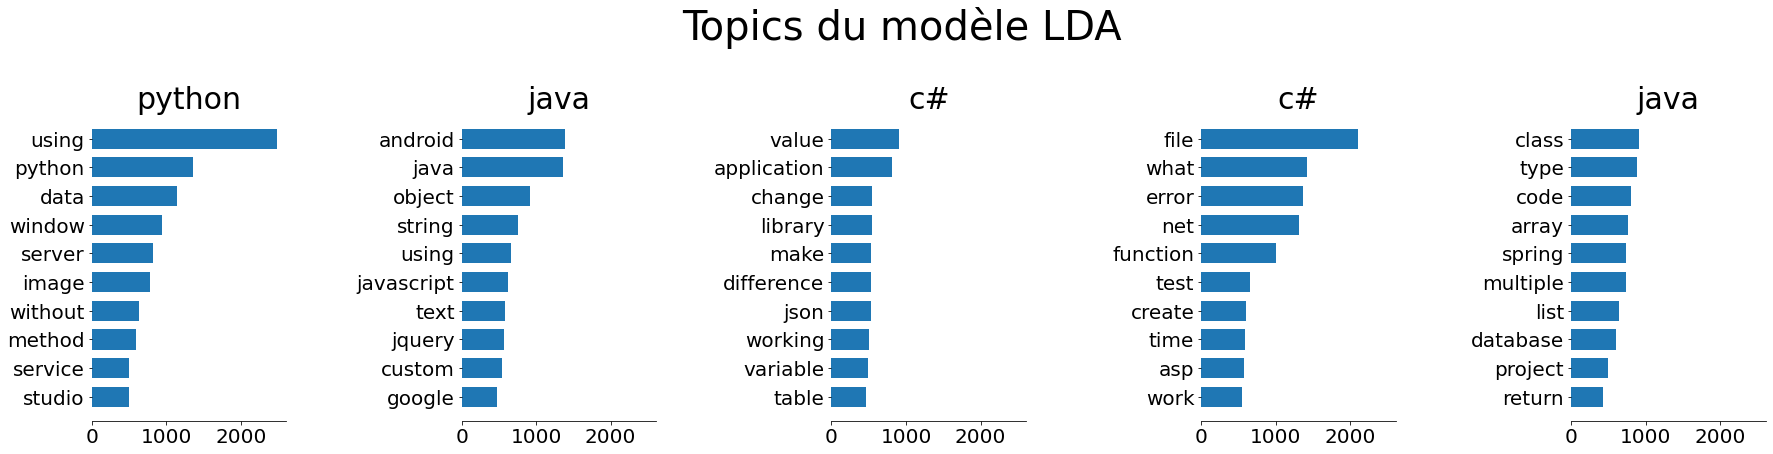

In [ ]:
lda_titles = optim_lda(X_train_count_titles, y_train_titles['Tags'])

Le premier problème qui apparaît est que plusieurs topics ont le même tag de référence.</br>
Deuxième problème, le score log-likelihood est négatif, signe d'un modèle non adapté.</br>
Le point positif est que la propotion de titres par topic est assez équilibrée.

Essayons une démarche semi-supervisée sur le jeu de test pour évaluer si le modèle peut tout de même être utilisable dans la pratique. Pour ce faire, on va prédire pour chaque titre le topic le plus probable et suggérer le tag de référence du topic. Pour évaluer la démarche on va simplement regarder si le tag suggéré est, ou non, présent dans la liste des tags réels.

In [ ]:
#On récupère le tag prédit ainsi que la liste des tags réels
res_lda_test_titles = pd.DataFrame(lda_titles.transform(X_test_count_titles), columns=['python', 'java', 'c#', 'c#', 'java'])
res_lda_test_titles['most_propable_topic'] = res_lda_test_titles.idxmax(axis=1)
res_lda_test_titles['tags'] = list(y_test_titles['Tags'].apply(lambda x: x.split()))

#On regarde si le tag suggéré est présent dans la liste des tags réels
l = []
for i in range(res_lda_test_titles.shape[0]):
  l.append(res_lda_test_titles.iloc[i, 5] in res_lda_test_titles.iloc[i, 6])
res_lda_test_titles['matching'] = l

res_lda_test_titles.head()

,python,java,c#,c#,java,most_propable_topic,tags,matching
0,0.20,0.20,0.200000,0.200000,0.200000,python,"[python, unit-testing, qt, refactoring, separa...",True
1,0.60,0.10,0.100000,0.100000,0.100000,python,"[scala, dataframe, apache-spark, error-handlin...",False
2,0.04,0.04,0.240003,0.440001,0.239996,c#,"[c#, html, asp.net-mvc, asp.net-mvc-3, multiline]",True
3,0.60,0.10,0.100000,0.100000,0.100000,python,"[php, wordpress, woocommerce, product, hook-wo...",False
4,0.10,0.10,0.600000,0.100000,0.100000,c#,"[c#, .net, winapi, keyboard-layout, registerho...",True


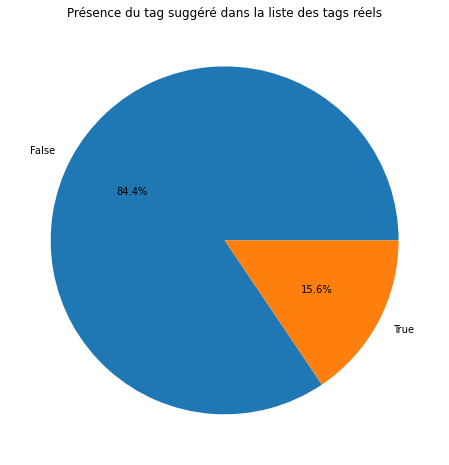

In [ ]:
#Affichage des résultats
plt.figure(figsize=(12, 8))
plt.pie(res_lda_test_titles['matching'].value_counts(), labels=['False', 'True'], autopct='%1.1f%%')
plt.title('Présence du tag suggéré dans la liste des tags réels')
plt.show()

Les résultats obtenus ne sont pas très probants. Pour seulement 15% des titres testés le tag suggéré correspond à un des tags qui avait été renseigné par l'utilisateur. Voyons si l'on obtient de meilleurs résultats en utilisant les questions

### **3.1.2: Détection de topics à partir des questions**

Modèle = LDA
 Best parameters: {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 15, 'n_jobs': -1}
Best log-likelihood score = -928327.9114076293
Execution time: 2687.4260873794556
    topic  nb_docs
0      11    15024
1       0     4004
2       6     3768
3       3     3694
4       7     2739
5       5     1922
6       1     1615
7      12     1534
8       9      938
9      14      874
10      2      847
11     10      801
12      8      792
13      4      762
14     13      686


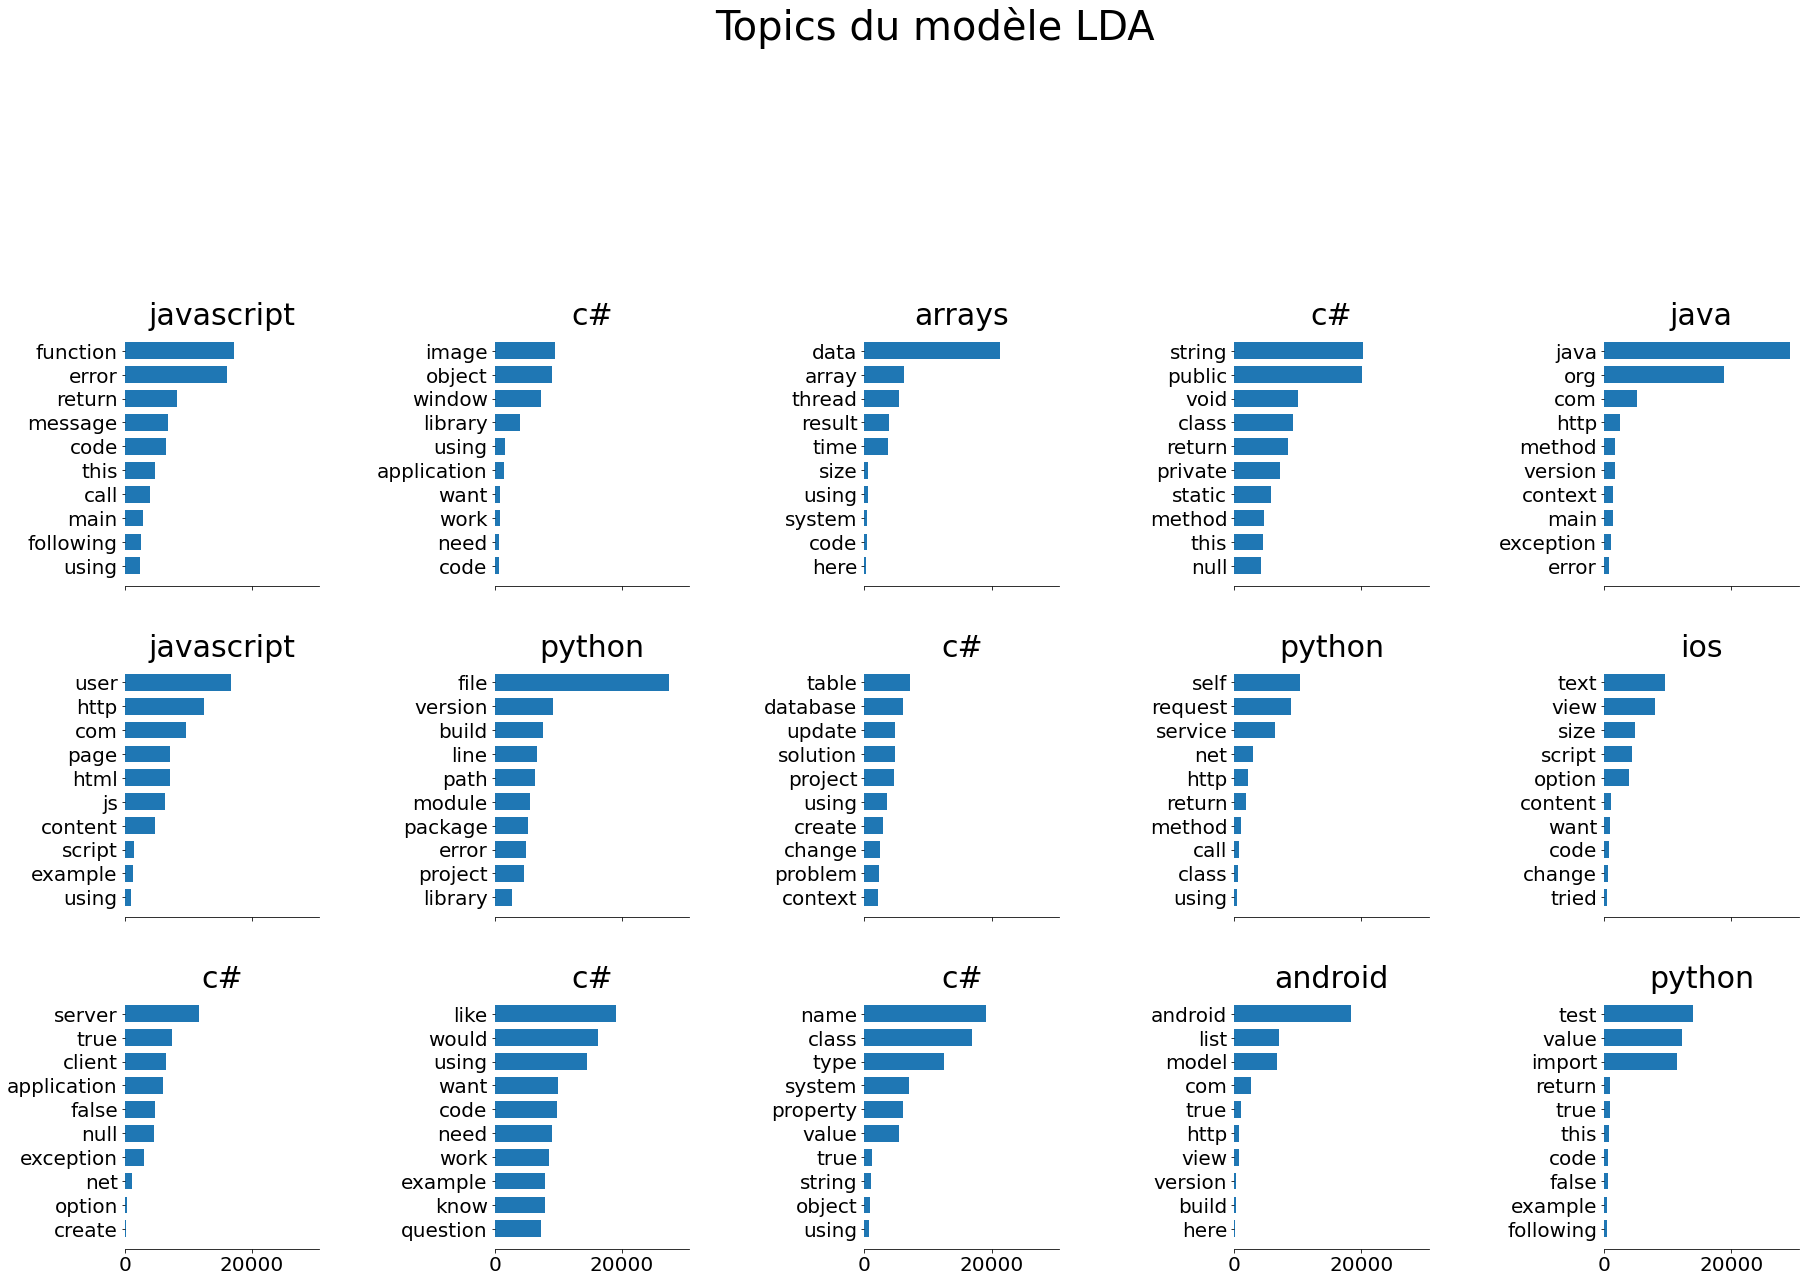

In [ ]:
lda_questions = optim_lda(X_train_count_questions, y_train_questions['Tags'])

On retrouve à nouveau le problème des topics qui ont le même tag de référence. De plus, on a cette fois en plus une disproportion au niveau du nombre de questions par topics. Et toujours un score log-likelihood négatif.</br>
Regardons au niveau du jeu de test si on obtient un meilleur taux de matching.

In [ ]:
#On récupère le tag prédit ainsi que la liste des tags réels
columns = ['javascript', 'c#', 'arrays', 'c#', 'java', 'javascript', 'python', 'c#', 'python', 'ios', 'c#', 'c#', 'c#', 'android', 'python']
res_lda_test_questions = pd.DataFrame(lda_questions.transform(X_test_count_questions), columns=columns)
res_lda_test_questions['most_propable_topic'] = res_lda_test_questions.idxmax(axis=1)
res_lda_test_questions['tags'] = list(y_test_questions['Tags'].apply(lambda x: x.split()))

#On regarde si le tag suggéré est présent dans la liste des tags réels
l = []
for i in range(res_lda_test_questions.shape[0]):
  l.append(res_lda_test_questions.iloc[i, 15] in res_lda_test_questions.iloc[i, 16])
res_lda_test_questions['matching'] = l

res_lda_test_questions.head(3)

,javascript,c#,arrays,c#,java,javascript,python,c#,python,ios,c#,c#,c#,android,python,most_propable_topic,tags,matching
0,0.001709,0.001709,0.001709,0.031152,0.001709,0.140033,0.001709,0.092516,0.001709,0.387504,0.001709,0.331702,0.001709,0.001709,0.001709,ios,"[iphone, ios, xcode, cocoa, uiscrollview]",True
1,0.497616,0.011111,0.011111,0.011111,0.182254,0.186796,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,javascript,"[selenium, selenium-webdriver, cookies, webdri...",False
2,0.583409,0.116870,0.005128,0.005128,0.005128,0.005128,0.005128,0.005128,0.005128,0.005128,0.005128,0.149279,0.005128,0.005128,0.094032,javascript,"[javascript, date, constructor, typeerror, acr...",True


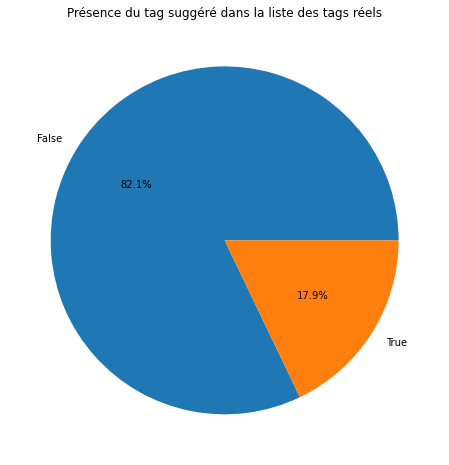

In [ ]:
#Affichage des résultats
plt.figure(figsize=(12, 8))
plt.pie(res_lda_test_questions['matching'].value_counts(), labels=['False', 'True'], autopct='%1.1f%%')
plt.title('Présence du tag suggéré dans la liste des tags réels')
plt.show()

Le taux de matching entre le tag suggéré et les tags réels est un peu meilleur qu'avec les titres mais reste cependant trop faible pour pouvoir être utilisé de façon pertinente.

Le premier problème avec cette méthode est le nombre de topics à chercher. Il faudrait très probablement chercher un beaucoup plus grand nombre de topics différents, car les questions recoupent des thématiques très variées et précises et sont très probablement uniques. En effet, on peut imaginer qu'une fois la question ayant trouvé réponse, personne ne reposera la même question ce qui réduit les possibilités de catégorisation des questions. On pourrait ainsi facilement augmenter le score log-likelihood en augmentant le nombre de topics à chercher mais on obtiendrait alors une quantité de topics inexploitable en pratique.</br>
Le second problème est la correpondance entre les topics et les tags. Même si on obtenait des topics distincts facilement exploitables, certains tags pourrait très bien convenir à chaque topics. On peut par exemple imaginer des topics liés à des problèmes de programmation indépendants du langage utilisé et par conséquent des tags comme **python**, **c#** ou encore **java** pourrait très bien convenir mais on ne disposerait d'aucune information pour savoir lequel est le plus adapté.


En conclusion, l'approche LDA est intéressante pour mieux comprendre les données et en obtenir une représentation un peu plus imagée mais n'est pas la solution pour notre problématique de suggestion de tags.

# <a name="C5">Partie 4: Classification supervisée des tags</a>

Dans cette partie nous allons essayer des méthodes de classification supervisée. Nous sommes dans un cas très particulier de classifiction multi-labels, c'est-à-dire qu'une entrée peut avoir plusieurs sorties. Dans notre cas, pour un titre ou une question donné, on veut pouvoir (potentiellement) suggérer plusieurs tags distincts.</br>
Pour ce faire, on va créer un classifieur pour chaque tag puis regarder la probabilité d'appartenance d'une entrée à chaque classe (représentant un tag ici).</br>
Dans un premier temps nous utiliserons une représentation en bag of words pour les titres/questions et les labels en limitant à chaque fois aux 100 mots les plus courants.

On définit ci-dessous les fonctions permettant de définir un classifieur individuel puis tous les classifieurs que l'on stocke dans un dictionnaire.

In [ ]:
def fit_one_classifier(X, y, model):
  """Fonction pour fitter un classifier avec une target unique"""
  y = y.values

  #Grille d'hyperparamètres en fonction du modèle
  if model == "decision_tree":
    classifier = DecisionTreeClassifier()

  elif model == "random_forest":
    classifier = RandomForestClassifier()

  elif model == "naive_bayes":  
    classifier = MultinomialNB()

  elif model == "logistic_regression":
      classifier = LogisticRegression()
        
  #Entraînement du modèle
  return classifier.fit(X, y)

def fit_all_classifiers(X, y_full, labels, model):
  """Fonction qui renvoie un dictionnaire contenant un classifier fitté pour chaque label"""

  classifiers = {}
  for label in labels:
    target = y_full[label]
    classifier = fit_one_classifier(X, target, model)
    classifiers[label] = classifier
  return classifiers

On définit à présent les fonctions pour obtenir les probabilités d'appartenance d'une phrase puis d'un corpus aux différentes classes.

In [ ]:
def get_prediction_sentence(sentence, classifiers, labels):
  """Fonction qui renvoie la probabilité d'appartenance d'une question/titre à chaque classe (correspondant aux tags)"""

  x = sentence.to_numpy().reshape(1, -1)
  preds = []
  for label in labels:
    preds.append(classifiers[label].predict_proba(x)[0, 1])
  return preds

def get_prediction_all(X, classifiers, labels):
  """Fonction qui renvoie le tableau des probabilités d'appartenance d'un jeu de questions/titres à chaque classe (correspondant aux tags)"""

  start_time = timeit.default_timer()
  df_predict = pd.DataFrame(columns=labels)
  for idx in range(X.shape[0]):
    sentence = X.loc[idx, :]
    df_predict.loc[idx, :] = get_prediction_sentence(sentence, classifiers, labels)
  time = timeit.default_timer() - start_time
  return df_predict, time

Pour évaluer nos modèles nous utiliserons l'aire sous la courbe ROC ainsi que le temps de calcul.

In [ ]:
def get_roc_auc_score(y_true, y_preds):
  """Fonction qui retourne le score roc_auc moyen"""

  tab_score = []
  for i in range(y_true.shape[0]):
    try:
      tab_score.append(roc_auc_score(y_true.iloc[i,:].values, y_preds.iloc[i,:].values))
    except ValueError:
      pass
  return np.mean(tab_score)

In [ ]:
LABELS_titles = list(y_train_count_titles.columns)
LABELS_questions = list(y_train_count_questions.columns)

On va sauvegarder les tags utilisés pour le code final de notre application.

In [ ]:
pickle.dump(LABELS_titles, open('labels_titles.pkl','wb'))
pickle.dump(LABELS_questions, open('labels_questions.pkl','wb'))

In [ ]:
#Tableau de comparaison des scores des différents modèles
stats_titles = pd.DataFrame(index=['direct matching', 'naive bayes', 'decision tree', 'random forest', 'logistic regression'], 
                            columns=['temps calcul', 'roc auc'])
stats_questions = pd.DataFrame(index=['direct matching', 'naive bayes', 'decision tree', 'random forest', 'logistic regression'], 
                            columns=['temps calcul', 'roc auc'])

## <a name="C6">4.1: Direct Matching</a>
Avant de tester des modèles complexes on va commencer par une approche assez naïve qui consiste tout simplement à affecter 1 aux tags qui sont présents dans le titre ou la question, et 0 dans le cas contraire.

In [ ]:
def direct_matching(X, y):
  """Fonction qui prend en entrée un corpus de titres/questions et des tags, et renvoie le tableau de matching des tags"""  
  X_columns = X.columns
  y_columns = y.columns
    
  #On initialise le tableau de sortie avec des 0
  y_out = pd.DataFrame(0, index=np.arange(len(X)), columns=y_columns)
    
  #On parcourt les tokens et on met 1 dès qu'il y a match avec un tag
  start_time = timeit.default_timer()
  common_columns = y_columns.intersection(X_columns)
  for y_column in common_columns:
    y_out.loc[:, y_column] = [1 if val > 0 else 0 for val in X[y_column]] 
  time = timeit.default_timer() - start_time
    
  return y_out, time

### 4.1.1: Avec les titres

In [ ]:
direct_matching_titles, time_direct_matching_titles = direct_matching(X_test_count_titles, y_test_count_titles)
direct_matching_titles.head()

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,arrays,asp,authentication,azure,bash,boot,chrome,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,native,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,ui,unit,user,visual,web,windows,wpf,xcode,xml
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
roc_direct_matching_titles = get_roc_auc_score(y_test_count_titles, direct_matching_titles)
print(roc_direct_matching_titles)

0.5888641841512368


In [ ]:
stats_titles.loc['direct matching', 'temps calcul'] = time_direct_matching_titles
stats_titles.loc['direct matching', 'roc auc'] = roc_direct_matching_titles

Le score est plutôt correcte pour une approche naïve, mais regardons ce que cela représente en termes de proportions.

In [ ]:
direct_matching_titles['Total'] = direct_matching_titles.iloc[:,1:].sum(axis=1)

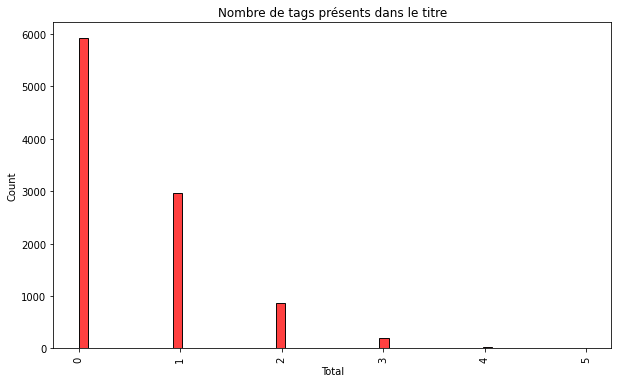

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(x='Total', data=direct_matching_titles, color='red')
plt.xticks(rotation=90)
plt.title('Nombre de tags présents dans le titre')
plt.show()

In [ ]:
direct_matching_titles['Total'].value_counts() / direct_matching_titles.shape[0]

0    0.5925
1    0.2965
2    0.0875
3    0.0206
4    0.0024
5    0.0005
Name: Total, dtype: float64

L'approche naïve avec les titres n'est pas la plus intéressante car pour 60% des titres testés aucun tag n'est directement présent dans les mots du titre. Toutefois les titres sont souvent très courts, peu précis, voir absents, essayons donc avec les questions.

### 4.1.2: Avec les questions

In [ ]:
direct_matching_questions, time_direct_matching_questions = direct_matching(X_test_count_questions, y_test_count_questions)
direct_matching_questions.head()

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,app,arrays,asp,authentication,azure,bash,boot,chrome,class,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,unit,user,visual,web,windows,wpf,xcode,xml
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
roc_direct_matching_questions = get_roc_auc_score(y_test_count_questions, direct_matching_questions)
print(roc_direct_matching_questions)

0.5721709199580844


In [ ]:
stats_questions.loc['direct matching', 'temps calcul'] = time_direct_matching_questions
stats_questions.loc['direct matching', 'roc auc'] = roc_direct_matching_questions

In [ ]:
direct_matching_questions['Total'] = direct_matching_questions.iloc[:,1:].sum(axis=1)

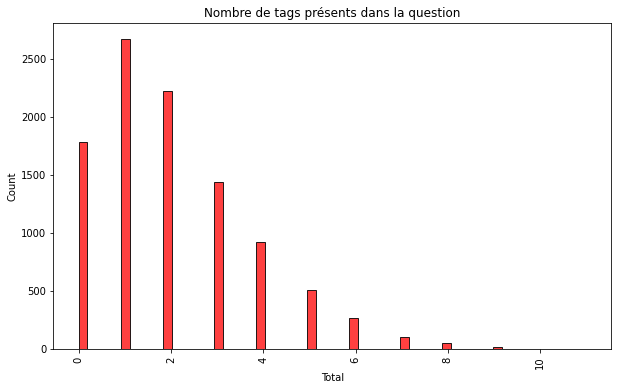

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(x='Total', data=direct_matching_questions, color='red')
plt.xticks(rotation=90)
plt.title('Nombre de tags présents dans la question')
plt.show()

In [ ]:
direct_matching_titles['Total'].value_counts() / direct_matching_titles.shape[0]

0    0.5925
1    0.2965
2    0.0875
3    0.0206
4    0.0024
5    0.0005
Name: Total, dtype: float64

Les résultats obtenus sont assez similaires. Même si ce n'est pas le modèle adéquat pour notre problématique, cette aproche pourrait très bien être utilisée en complément d'un autre modèle car simple d'utilisation et avec la possibilité de trouver des tags fiables.

## <a name="C7">4.2: Naïve Bayes</a>
La classification naïve bayésienne est un type de classification bayésienne probabiliste simple basée sur le théorème de Bayes avec une forte indépendance (dite naïve) des hypothèses. En termes simples, un classifieur bayésien naïf suppose que l'existence d'une caractéristique pour une classe, est indépendante de l'existence d'autres caractéristiques.
### 4.2.1: Avec les titres

In [ ]:
classifiers_naive_bayes_titles = fit_all_classifiers(X_train_count_titles, y_train_count_titles, LABELS_titles, "naive_bayes")

In [ ]:
y_preds_naive_bayes_titles, time_naive_bayes_titles = get_prediction_all(X_test_count_titles, classifiers_naive_bayes_titles, LABELS_titles)
y_preds_naive_bayes_titles.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,arrays,asp,authentication,azure,bash,boot,chrome,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,native,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,ui,unit,user,visual,web,windows,wpf,xcode,xml
0,0.016425,0.01155,0.013975,0.0057,0.03185,0.009425,0.00675,0.010375,0.018,0.01475,0.031025,0.009825,0.00225,0.009225,0.00905,0.007875,0.0144,0.01175,0.011225,0.024675,0.01895,0.017475,0.008925,0.01215,0.007075,0.0045,0.00845,0.007625,0.00305,0.0142,0.0026,0.012925,0.010575,0.0068,0.0186,0.00435,0.008625,0.042275,0.011975,0.01355,0.0133,0.0648,0.034425,0.1106,0.097475,0.007225,0.030575,0.0308,0.01675,0.009325,0.00285,0.00685,0.005775,0.025775,0.015,0.0066,0.01215,0.016825,0.022125,0.016425,0.005625,0.076925,0.023475,0.01035,0.03675,0.01505,0.008625,0.008075,0.0223,0.036575,0.00795,0.009375,0.076525,0.01335,0.005975,0.012925,0.00975,0.0123,0.01205,0.00295,0.017575,0.017525,0.01175,0.024375,0.0151,0.026175,0.018,0.007725,0.019,0.010825,0.008925,0.006225,0.01485,0.00915,0.0214,0.03145,0.02455,0.0149,0.018575,0.010875
1,0.020216,0.010046,0.003892,0.005167,0.031928,0.002126,0.002096,0.009004,0.014958,0.005874,0.035924,0.014553,0.006385,0.002716,0.019628,0.00571,0.012181,0.010892,0.020494,0.006395,0.007301,0.00261,0.048575,0.01185,0.012324,0.002414,0.022496,0.009557,0.002291,0.008279,0.001778,0.01558,0.014471,0.003049,0.010829,0.001805,0.026949,0.008264,0.004167,0.004971,0.017346,0.045119,0.013316,0.221932,0.023101,0.021176,0.006926,0.012091,0.016827,0.006205,0.006669,0.003089,0.011309,0.011716,0.014951,0.010365,0.015895,0.026027,0.031857,0.020587,0.005967,0.141887,0.011971,0.005769,0.03567,0.01061,0.003294,0.005009,0.011782,0.027969,0.007031,0.005813,0.032209,0.010346,0.001959,0.002198,0.01445,0.013708,0.011366,0.008266,0.009095,0.018617,0.027621,0.021606,0.006751,0.033383,0.01579,0.003868,0.025437,0.007735,0.002118,0.004718,0.02206,0.005252,0.030622,0.0385,0.015396,0.007096,0.007635,0.020514
2,0.000176,0.00019,0.003264,0.000835,0.009164,0.001252,0.007411,0.005074,0.000029,0.004526,0.001159,0.000082,0.000865,0.046966,0.000088,0.015865,0.074441,0.00224,0.001435,0.456641,0.003858,0.000608,0.001153,0.016815,0.001666,0.005817,0.015092,0.000133,0.001124,0.031957,0.002637,0.00329,0.010914,0.007795,0.014808,0.000804,0.001494,0.169612,0.000189,0.012371,0.08854,0.315355,0.190426,0.070447,0.044806,0.000599,0.035774,0.001486,0.001195,0.004274,0.000813,0.002675,0.000311,0.022838,0.01703,0.001449,0.003778,0.000798,0.000316,0.003043,0.00308,0.005028,0.000168,0.001694,0.235626,0.001823,0.000849,0.005214,0.005658,0.040153,0.003374,0.004283,0.065173,0.00236,0.00408,0.008916,0.000148,0.004329,0.000255,0.001644,0.004572,0.000501,0.000717,0.001268,0.002501,0.001251,0.037179,0.000706,0.000123,0.088376,0.000659,0.043344,0.000121,0.0289,0.001189,0.000231,0.004966,0.015084,0.066273,0.024939


In [ ]:
roc_naive_bayes_titles = get_roc_auc_score(y_test_count_titles, y_preds_naive_bayes_titles)
print(roc_naive_bayes_titles)

0.8292910334404402


In [ ]:
stats_titles.loc['naive bayes', 'temps calcul'] = time_naive_bayes_titles
stats_titles.loc['naive bayes', 'roc auc'] = roc_naive_bayes_titles

### 4.2.2: Avec les questions

In [ ]:
classifiers_naive_bayes_questions = fit_all_classifiers(X_train_count_questions, y_train_count_questions, LABELS_questions, "naive_bayes")

In [ ]:
y_preds_naive_bayes_questions, time_naive_bayes_questions = get_prediction_all(X_test_count_questions, classifiers_naive_bayes_questions, 
                                                                               LABELS_questions)
y_preds_naive_bayes_questions.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,app,arrays,asp,authentication,azure,bash,boot,chrome,class,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,unit,user,visual,web,windows,wpf,xcode,xml
0,0.0,0.003427,0.0,0.0,0.015777,0.0,0.100426,0.0,0.000016,0.0,0.0,0.004757,0.000002,0.0,0.0,0.0,0.004221,0.0,0.999998,0.000022,0.003637,0.901064,0.0,0.0,0.00073,0.214893,0.000001,0.0,0.0,0.000033,0.978329,0.0,0.0,0.001824,0.0,0.000023,0.000011,0.0,0.0,0.866153,0.000007,0.829252,0.725387,0.999758,1.0,0.0,0.062201,0.0,0.020618,0.000021,0.0,0.0,0.000066,0.0,0.0,0.0,0.000456,0.0,0.000066,0.0,0.000052,0.0,0.00011,0.0,0.0,1.0,0.002677,0.0,0.0,0.000242,0.00012,0.0,0.000001,0.000003,0.029066,0.0,0.000008,0.0,0.034316,0.0,0.000001,0.000017,0.0,0.0,0.000001,0.0,0.000001,0.998001,0.000069,0.0,1.0,0.0,0.0,0.959242,0.000011,0.0,0.000001,0.203637,0.99992,0.0
1,0.007735,0.011232,0.000054,0.0062,0.015325,0.006708,0.019607,0.025744,0.002401,0.007692,0.000393,0.002264,0.012829,0.000198,0.002406,0.005627,0.011931,0.00034,0.000154,0.008037,0.000774,0.009716,0.009765,0.002666,0.001281,0.000676,0.003458,0.003798,0.01022,0.000066,0.001213,0.007361,0.004706,0.000957,0.002488,0.002338,0.032952,0.00179,0.001002,0.030008,0.006369,0.002066,0.000673,0.011157,0.003265,0.091323,0.067628,0.000575,0.022828,0.011379,0.011398,0.000669,0.000147,0.000605,0.000009,0.013793,0.012302,0.003082,0.0012,0.00017,0.043813,0.012176,0.004821,0.006324,0.001214,0.002017,0.015727,0.000135,0.004837,0.000328,0.011616,0.003732,0.000998,0.020513,0.005818,0.005716,0.002604,0.005813,0.013306,0.03046,0.002655,0.001273,0.013514,0.00629,0.002267,0.000784,0.019048,0.000335,0.006533,0.009945,0.000136,0.000694,0.004775,0.000174,0.00095,0.041471,0.004396,0.000079,0.003299,0.009775
2,0.106255,0.003097,0.000189,0.002097,0.000836,0.021353,0.001521,0.001045,0.005441,0.00159,0.003865,0.012266,0.004344,0.003779,0.061887,0.0,0.121544,0.002169,0.17488,0.020598,0.023566,0.006883,0.00283,0.00144,0.342718,0.000035,0.000197,0.00246,0.000225,0.000068,0.001771,0.001167,0.00008,0.001071,0.416439,0.007043,0.009887,0.0,0.0,0.029542,0.003934,0.003838,0.010598,0.430509,0.318828,0.000255,0.326796,0.0,0.031729,0.031308,0.000499,0.004367,0.000094,0.005232,0.000123,0.173493,0.182895,0.000003,0.010398,0.003752,0.000302,0.000574,0.071248,0.01,0.097528,0.292928,0.010713,0.00155,0.078031,0.001863,0.014212,0.004145,0.025324,0.123365,0.005668,0.006702,0.048958,0.000023,0.0086,0.001014,0.015897,0.016762,0.00147,0.0,0.010922,0.003241,0.027291,0.085066,0.011721,0.001627,0.065925,0.013508,0.000524,0.011117,0.366245,0.005037,0.564527,0.064914,0.204983,0.000042


In [ ]:
roc_naive_bayes_questions = get_roc_auc_score(y_test_count_questions, y_preds_naive_bayes_questions)
print(roc_naive_bayes_questions)

0.8406848630794231


In [ ]:
stats_questions.loc['naive bayes', 'temps calcul'] = time_naive_bayes_questions
stats_questions.loc['naive bayes', 'roc auc'] = roc_naive_bayes_questions

## <a name="C8">4.3: Arbre de Décision</a>
L’apprentissage par arbre de décision désigne une méthode basée sur l'utilisation d'un arbre de décision comme modèle prédictif. Les décisions possibles sont situées aux extrémités des branches (les « feuilles » de l’arbre) et sont atteintes en fonction de décisions prises à chaque étape. Un arbre de décision fonctionne en appliquant de manière itérative des règles logiques très simples (typiquement des séparations de données par « hyperplan », généralisation d’un plan à plus de 2 dimensions), chaque règle étant choisie en fonction du résultat de la règle précédente.
### 4.3.1: Avec les titres

In [ ]:
classifiers_decision_tree_titles = fit_all_classifiers(X_train_count_titles, y_train_count_titles, LABELS_titles, "decision_tree")

In [ ]:
y_preds_decision_tree_titles, time_decision_tree_titles = get_prediction_all(X_test_count_titles, classifiers_decision_tree_titles, LABELS_titles)
y_preds_decision_tree_titles.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,arrays,asp,authentication,azure,bash,boot,chrome,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,native,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,ui,unit,user,visual,web,windows,wpf,xcode,xml
0,0.021,0.005196,0.021866,0.006278,0.022949,0.005845,0.003572,0.011474,0.013856,0.003356,0.017536,0.007686,0.001732,0.008552,0.002598,0.008552,0.021866,0.005954,0.010825,0.026304,0.015588,0.01299,0.010175,0.012882,0.003789,0.005196,0.008768,0.004222,0.004438,0.004871,0.00249,0.008335,0.016021,0.008443,0.016346,0.004113,0.008985,0.038753,0.00617,0.008768,0.013639,0.102403,0.055423,0.090171,0.068846,0.008552,0.018294,0.020784,0.006062,0.012016,0.003031,0.008768,0.003897,0.023382,0.021541,0.007144,0.009634,0.016995,0.009309,0.016021,0.002381,0.061593,0.016562,0.010175,0.059428,0.010933,0.012124,0.006603,0.022191,0.036588,0.006062,0.009742,0.063217,0.009526,0.002165,0.006387,0.005954,0.011907,0.012557,0.003031,0.010933,0.017969,0.006603,0.019809,0.006387,0.013964,0.027712,0.004005,0.013531,0.016346,0.005521,0.004871,0.010067,0.009093,0.013315,0.029444,0.017212,0.020351,0.027603,0.009201
1,0.012821,0.012821,0.0,0.0,0.051282,0.0,0.0,0.012821,0.025641,0.012821,0.025641,0.0,0.025641,0.0,0.038462,0.0,0.0,0.0,0.012821,0.0,0.0,0.0,0.102564,0.0,0.012821,0.0,0.038462,0.012821,0.0,0.0,0.0,0.025641,0.025641,0.0,0.0,0.0,0.051282,0.0,0.0,0.0,0.0,0.038462,0.012821,0.25641,0.025641,0.025641,0.0,0.012821,0.0,0.0,0.0,0.0,0.0,0.012821,0.0,0.012821,0.0,0.038462,0.051282,0.025641,0.0,0.128205,0.012821,0.0,0.0,0.012821,0.0,0.0,0.012821,0.025641,0.0,0.0,0.012821,0.012821,0.0,0.0,0.025641,0.012821,0.0,0.012821,0.0,0.012821,0.025641,0.0,0.0,0.038462,0.025641,0.0,0.025641,0.0,0.0,0.012821,0.012821,0.0,0.051282,0.025641,0.012821,0.0,0.012821,0.038462
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.111111,0.222222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.5,0.0,0.333333,1.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
roc_decision_tree_titles = get_roc_auc_score(y_test_count_titles, y_preds_decision_tree_titles)
print(roc_decision_tree_titles)

0.7649657232871132


In [ ]:
stats_titles.loc['decision tree', 'temps calcul'] = time_decision_tree_titles
stats_titles.loc['decision tree', 'roc auc'] = roc_decision_tree_titles

### 4.3.2: Avec les questions

In [ ]:
classifiers_decision_tree_questions = fit_all_classifiers(X_train_count_questions, y_train_count_questions, LABELS_questions, "decision_tree")

In [ ]:
y_preds_decision_tree_questions, time_decision_tree_questions = get_prediction_all(X_test_count_questions, classifiers_decision_tree_questions, 
                                                                                   LABELS_questions)
y_preds_decision_tree_questions.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,app,arrays,asp,authentication,azure,bash,boot,chrome,class,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,unit,user,visual,web,windows,wpf,xcode,xml
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
roc_decision_tree_questions = get_roc_auc_score(y_test_count_questions, y_preds_decision_tree_questions)
print(roc_decision_tree_questions)

0.5876952087303802


In [ ]:
stats_questions.loc['decision tree', 'temps calcul'] = time_decision_tree_questions
stats_questions.loc['decision tree', 'roc auc'] = roc_decision_tree_questions

## <a name="C9">4.4: Forêt aléatoire</a>
La forêt aléatoire est composée de plusieurs arbres de décision, travaillant de manière indépendante sur une vision d'un problème. Chacun produit une estimation, et c'est l'assemblage des arbres de décision et de leurs analyses, qui va donner une estimation globale. En somme, il s'agit de s'inspirer de différents avis, traitant un même problème, pour mieux l'appréhender. Chaque modèle est distribué de façon aléatoire aux sous-ensembles d'arbres décisionnels.
### 4.4.1: Avec les titres

In [ ]:
classifiers_random_forest_titles = fit_all_classifiers(X_train_count_titles, y_train_count_titles, LABELS_titles, "random_forest")

In [ ]:
y_preds_random_forest_titles, time_random_forest_titles = get_prediction_all(X_test_count_titles, classifiers_random_forest_titles, LABELS_titles)
y_preds_random_forest_titles.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,arrays,asp,authentication,azure,bash,boot,chrome,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,native,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,ui,unit,user,visual,web,windows,wpf,xcode,xml
0,0.020852,0.005099,0.021486,0.006346,0.023235,0.005881,0.00355,0.011336,0.013723,0.003266,0.017474,0.007651,0.001759,0.008388,0.00259,0.008687,0.021968,0.005852,0.010953,0.026357,0.015472,0.013089,0.010218,0.012971,0.003719,0.00506,0.008709,0.004293,0.004428,0.004957,0.002533,0.008429,0.016237,0.008478,0.016484,0.004192,0.008896,0.038702,0.006144,0.008604,0.013447,0.102325,0.055767,0.089893,0.069251,0.008533,0.01827,0.020813,0.005938,0.011933,0.00295,0.008694,0.003941,0.023561,0.02173,0.007037,0.009682,0.01708,0.009273,0.016125,0.002413,0.061495,0.016396,0.010158,0.059637,0.011071,0.012057,0.006459,0.022291,0.03671,0.006165,0.009705,0.062903,0.009557,0.002177,0.00637,0.005915,0.011836,0.012543,0.003061,0.010954,0.018041,0.006552,0.019843,0.006289,0.014143,0.027782,0.004037,0.013562,0.016066,0.005499,0.00479,0.010022,0.009027,0.013155,0.029454,0.017085,0.020424,0.027618,0.009107
1,0.011544,0.013509,0.0,0.0,0.048601,0.0,0.0,0.013987,0.027007,0.012215,0.025907,0.0,0.025979,0.0,0.039708,0.0,0.0,0.0,0.011791,0.0,0.0,0.0,0.105393,0.0,0.012356,0.0,0.035661,0.012728,0.0,0.0,0.0,0.027731,0.027305,0.0,0.0,0.0,0.051258,0.0,0.0,0.0,0.0,0.037706,0.011375,0.262468,0.026419,0.025001,0.0,0.014246,0.0,0.0,0.0,0.0,0.0,0.013455,0.0,0.010827,0.0,0.037973,0.050743,0.025474,0.0,0.12956,0.012878,0.0,0.0,0.014201,0.0,0.0,0.013173,0.023119,0.0,0.0,0.012565,0.011929,0.0,0.0,0.027582,0.011312,0.0,0.012917,0.0,0.013224,0.027529,0.0,0.0,0.037104,0.025352,0.0,0.026497,0.0,0.0,0.011582,0.013377,0.0,0.055144,0.028791,0.014637,0.0,0.012775,0.036315
2,0.0,0.0,0.002301,0.0,0.0,0.0,0.000845,0.0,0.0,0.0,0.000553,0.0,0.0,0.48,0.0,0.000156,0.131923,0.000224,0.042256,0.12982,0.288903,0.00119,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000159,0.0,0.002069,0.003995,0.0,0.161666,0.323355,0.202159,0.240375,0.240235,0.101779,0.000384,0.001778,0.0,0.060529,0.001045,0.001211,0.0,0.0,0.440761,0.00061,0.0,0.0,0.0,0.0,0.042188,0.0,0.000885,0.0,0.0,0.132696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033961,0.0004,0.0,0.047824,0.0,0.000185,0.0,0.0,0.000339,0.0,0.290973,0.04134,0.0,0.0,0.000122,0.031197,0.0,0.134906,0.01,0.112762,0.0,0.1365,0.0,0.000348,0.0,0.000127,0.0,0.000608


In [ ]:
roc_random_forest_titles = get_roc_auc_score(y_test_count_titles, y_preds_random_forest_titles)
print(roc_random_forest_titles)

0.805890372774007


In [ ]:
stats_titles.loc['random forest', 'temps calcul'] = time_random_forest_titles
stats_titles.loc['random forest', 'roc auc'] = roc_random_forest_titles

### 4.4.2: Avec les questions

In [ ]:
classifiers_random_forest_questions = fit_all_classifiers(X_train_count_questions, y_train_count_questions, LABELS_questions, "random_forest")

In [ ]:
y_preds_random_forest_questions, time_random_forest_questions = get_prediction_all(X_test_count_questions, classifiers_random_forest_questions, 
                                                                                   LABELS_questions)
y_preds_random_forest_questions.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,app,arrays,asp,authentication,azure,bash,boot,chrome,class,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,unit,user,visual,web,windows,wpf,xcode,xml
0,0.01,0.05,0.01,0.0,0.01,0.09,0.07,0.07,0.0,0.02,0.05,0.06,0.0,0.0,0.0,0.04,0.05,0.0,0.09,0.02,0.03,0.2,0.02,0.0,0.01,0.01,0.0,0.0,0.04,0.0,0.01,0.01,0.0,0.04,0.05,0.0,0.06,0.0,0.0,0.28,0.0,0.01,0.13,0.4,0.3,0.06,0.28,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.03,0.0,0.03,0.0,0.05,0.0,0.05,0.0,0.0,0.34,0.03,0.0,0.0,0.01,0.02,0.01,0.01,0.03,0.0,0.01,0.02,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.01,0.01,0.02,0.11,0.0,0.02,0.09,0.0,0.01,0.03,0.0,0.02,0.0,0.02,0.09,0.02
1,0.025,0.02,0.001769,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.01,0.0,0.0,0.001429,0.0,0.0,0.0025,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.02,0.41,0.0,0.0,0.0,0.0425,0.01125,0.06,0.3,0.01,0.03,0.032,0.0,0.00125,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.05,0.02,0.052308,0.0,0.0,0.04,0.0,0.0,0.0,0.07,0.0,0.0,0.03,0.01,0.0,0.0,0.0,0.00125,0.01,0.0,0.0,0.02,0.01,0.001625,0.001667,0.0,0.0,0.01,0.0,0.0,0.001667,0.0,0.0,0.0,0.03,0.0,0.0,0.11,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.02,0.02,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.08,0.01,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.06,0.02,0.01,0.01


In [ ]:
roc_random_forest_questions = get_roc_auc_score(y_test_count_questions, y_preds_random_forest_questions)
print(roc_random_forest_questions)

0.846011955447592


In [ ]:
stats_questions.loc['random forest', 'temps calcul'] = time_random_forest_questions
stats_questions.loc['random forest', 'roc auc'] = roc_random_forest_questions

## <a name="C10">4.5: Régression logistique</a>


La régression logistique est un modèle statistique permettant d’étudier les relations entre un ensemble de variables qualitatives Xi et une variable qualitative Y. Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien. Un modèle de régression logistique permet aussi de prédire la probabilité qu’un événement arrive (valeur de 1) ou non (valeur de 0) à partir de l’optimisation des coefficients de régression. Lorsque la valeur prédite est supérieure à un seuil, l’événement est susceptible de se produire, alors que lorsque cette valeur est inférieure au même seuil, il ne l’est pas.

### 4.5.1: Avec les titres

In [ ]:
classifiers_logistic_regression_titles = fit_all_classifiers(X_train_count_titles, y_train_count_titles, LABELS_titles, "logistic_regression")

In [ ]:
y_preds_logistic_regression_titles, time_logistic_regression_titles = get_prediction_all(X_test_count_titles, classifiers_logistic_regression_titles, 
                                                                                         LABELS_titles)
y_preds_logistic_regression_titles.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,arrays,asp,authentication,azure,bash,boot,chrome,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,native,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,ui,unit,user,visual,web,windows,wpf,xcode,xml
0,0.022375,0.007025,0.021424,0.006318,0.022462,0.005271,0.005006,0.012144,0.015678,0.005028,0.020528,0.00878,0.001839,0.009425,0.003375,0.008707,0.02229,0.007936,0.009734,0.028897,0.015106,0.015087,0.009662,0.013741,0.00282,0.00472,0.009582,0.004752,0.003412,0.006477,0.002153,0.009224,0.015425,0.009157,0.01551,0.002927,0.009281,0.038528,0.007913,0.008123,0.013935,0.099956,0.054014,0.08974,0.074369,0.007999,0.019361,0.023443,0.00702,0.01227,0.003414,0.008718,0.00535,0.024289,0.021333,0.006994,0.008591,0.015025,0.013094,0.017567,0.002921,0.063434,0.018425,0.010496,0.05778,0.01159,0.011347,0.007584,0.020716,0.039404,0.006713,0.00986,0.065642,0.009984,0.002479,0.006481,0.006844,0.011334,0.012921,0.00285,0.01218,0.016339,0.00676,0.021836,0.00805,0.016553,0.026251,0.003803,0.014066,0.016404,0.005956,0.005652,0.010934,0.008636,0.015479,0.030598,0.017878,0.020014,0.026178,0.009879
1,0.022157,0.007112,0.004041,0.00342,0.029426,0.001604,0.001608,0.007767,0.010546,0.00394,0.026985,0.013798,0.005758,0.002868,0.005475,0.00473,0.011322,0.006928,0.013851,0.008644,0.005887,0.002753,0.050335,0.011456,0.006227,0.0014,0.017743,0.008745,0.001692,0.007654,0.00128,0.015771,0.013862,0.002343,0.006552,0.000823,0.023816,0.012305,0.003694,0.004321,0.015522,0.05139,0.014176,0.177484,0.025617,0.016134,0.007621,0.012167,0.01189,0.005608,0.006972,0.002542,0.010623,0.011383,0.013988,0.00708,0.009298,0.018586,0.019387,0.023487,0.003841,0.138569,0.012466,0.00507,0.037575,0.005529,0.002661,0.004967,0.011055,0.034114,0.005948,0.005113,0.029931,0.005221,0.001118,0.001985,0.009651,0.008451,0.008178,0.006256,0.007161,0.01556,0.015414,0.019305,0.004813,0.02873,0.015887,0.001567,0.015465,0.007331,0.001728,0.004374,0.014208,0.004426,0.02884,0.034208,0.015463,0.007639,0.006953,0.018321
2,0.000219,0.000373,0.00106,0.000202,0.010319,0.002419,0.010361,0.002944,0.000072,0.007415,0.005661,0.000106,0.000523,0.015017,0.000192,0.009734,0.017107,0.003541,0.002988,0.24896,0.006167,0.001117,0.001008,0.01376,0.004297,0.001454,0.010505,0.000284,0.000292,0.023876,0.001274,0.006729,0.004525,0.001879,0.018388,0.000557,0.001766,0.11283,0.000525,0.009042,0.042122,0.090598,0.053205,0.155522,0.081321,0.000524,0.062093,0.001426,0.007556,0.003378,0.000164,0.001447,0.000319,0.010497,0.003966,0.000719,0.009695,0.001376,0.003181,0.003199,0.004613,0.013529,0.000193,0.001116,0.062173,0.001733,0.000325,0.004381,0.008894,0.024331,0.003347,0.001389,0.0483,0.002382,0.004676,0.017938,0.000423,0.002875,0.000358,0.000748,0.011037,0.001075,0.001112,0.00274,0.005447,0.005368,0.008773,0.004343,0.000413,0.020745,0.001478,0.026288,0.00053,0.016569,0.005996,0.000549,0.00317,0.003286,0.0168,0.017446


In [ ]:
roc_logistic_regression_titles = get_roc_auc_score(y_test_count_titles, y_preds_logistic_regression_titles)
print(roc_logistic_regression_titles)

0.8370633802717092


In [ ]:
stats_titles.loc['logistic regression', 'temps calcul'] = time_logistic_regression_titles
stats_titles.loc['logistic regression', 'roc auc'] = roc_logistic_regression_titles

### 4.5.2: Avec les questions

In [ ]:
classifiers_logistic_regression_questions = fit_all_classifiers(X_train_count_questions, y_train_count_questions, LABELS_questions,
                                                                "logistic_regression")

In [ ]:
y_preds_logistic_regression_questions, time_logistic_regression_questions = get_prediction_all(X_test_count_questions, 
                                                                                               classifiers_logistic_regression_questions,
                                                                                               LABELS_questions)
y_preds_logistic_regression_questions.head(3)

,11,ajax,algorithm,amazon,android,angular,angularjs,apache,api,app,arrays,asp,authentication,azure,bash,boot,chrome,class,cocoa,code,core,css,data,database,debugging,design,django,docker,eclipse,entity,facebook,file,firebase,framework,gcc,git,google,gradle,hibernate,html,http,image,interface,ios,iphone,java,javascript,jpa,jquery,js,json,language,laravel,learning,linq,linux,macos,maven,memory,multithreading,mvc,mysql,net,node,numpy,objective,on,optimization,pandas,performance,php,postgresql,processing,python,rails,react,reactjs,rest,ruby,security,selenium,server,services,spring,sql,string,studio,swift,templates,testing,touch,typescript,unit,user,visual,web,windows,wpf,xcode,xml
0,0.0,0.018862,0.000003,0.000001,0.10619,0.002069,0.024994,0.002405,0.005769,0.000138,0.000148,0.027545,0.000668,0.000914,0.000001,0.000566,0.000579,0.000038,0.021393,0.009531,0.009556,0.027334,0.002772,0.00015,0.007424,0.002471,0.000294,0.000002,0.008769,0.003394,0.00027,0.000068,0.001402,0.010735,0.0,0.000616,0.003802,0.001219,0.000669,0.028859,0.008273,0.013081,0.020764,0.609721,0.241412,0.029429,0.06023,0.002963,0.018366,0.029838,0.006146,0.0,0.000488,0.000001,0.000073,0.000024,0.010292,0.0,0.004103,0.000038,0.057006,0.000146,0.01879,0.003241,0.0,0.154099,0.010622,0.000013,0.0,0.003513,0.004475,0.000713,0.000042,0.001215,0.011082,0.015405,0.013885,0.000654,0.00603,0.000374,0.000163,0.002652,0.000318,0.004855,0.001136,0.000009,0.021336,0.030965,0.001904,0.000834,0.030637,0.000576,0.000091,0.02553,0.009309,0.003733,0.000219,0.008179,0.033828,0.008752
1,0.024577,0.011746,0.003657,0.005145,0.0187,0.011204,0.011809,0.013184,0.015319,0.008874,0.01849,0.014146,0.012549,0.001143,0.022952,0.008834,0.012998,0.007283,0.005858,0.011548,0.008789,0.043589,0.016708,0.017289,0.009259,0.009971,0.017611,0.005707,0.012207,0.003491,0.003769,0.011726,0.003251,0.014498,0.015179,0.011532,0.024812,0.00694,0.007654,0.08254,0.012393,0.01805,0.012506,0.092865,0.033526,0.099535,0.126048,0.004646,0.044286,0.031497,0.017231,0.008613,0.001976,0.016221,0.002123,0.039913,0.012838,0.005647,0.006814,0.007162,0.025548,0.027628,0.061918,0.020736,0.029348,0.046044,0.016555,0.005356,0.021115,0.00551,0.04083,0.009139,0.009597,0.096674,0.015615,0.006475,0.013386,0.008695,0.015478,0.018774,0.003149,0.015677,0.020626,0.012761,0.015451,0.032112,0.030021,0.01162,0.016243,0.01883,0.005592,0.005465,0.015103,0.0048,0.011866,0.03953,0.020282,0.002128,0.032376,0.013578
2,0.036522,0.008844,0.000529,0.004685,0.010093,0.01041,0.004094,0.008313,0.016413,0.008572,0.01074,0.022142,0.010696,0.005088,0.010791,0.002454,0.024445,0.014661,0.040073,0.016295,0.015105,0.016033,0.017269,0.006239,0.030322,0.001871,0.002763,0.005762,0.014458,0.002542,0.001534,0.007966,0.00157,0.009085,0.031247,0.002957,0.029746,0.001577,0.001635,0.048277,0.010663,0.008402,0.012929,0.124752,0.078678,0.055995,0.143805,0.001614,0.037867,0.027632,0.007755,0.004693,0.001183,0.005191,0.002358,0.04686,0.031805,0.004752,0.009073,0.015982,0.013151,0.004568,0.062127,0.017617,0.027442,0.083988,0.012762,0.00208,0.026266,0.004288,0.02694,0.004967,0.014134,0.086181,0.008213,0.009022,0.021807,0.002028,0.008456,0.0111,0.00893,0.016297,0.013604,0.001367,0.019567,0.009452,0.051345,0.030394,0.006616,0.010827,0.024583,0.012082,0.007965,0.008671,0.066547,0.024229,0.074002,0.03415,0.036545,0.006897


In [ ]:
roc_logistic_regression_questions = get_roc_auc_score(y_test_count_questions, y_preds_logistic_regression_questions)
print(roc_logistic_regression_questions)

0.8660824161814091


In [ ]:
stats_questions.loc['logistic regression', 'temps calcul'] = time_logistic_regression_questions
stats_questions.loc['logistic regression', 'roc auc'] = roc_logistic_regression_questions

## <a name="11">4.6: Choix du modèle</a>

In [ ]:
stats_titles

,temps calcul,roc auc
direct matching,0.220281,0.588864
naive bayes,189.204985,0.829291
decision tree,145.931799,0.764966
random forest,11020.770731,0.80589
logistic regression,134.458623,0.837063


In [ ]:
stats_questions

,temps calcul,roc auc
direct matching,0.082623,0.572171
naive bayes,173.253978,0.840685
decision tree,139.677479,0.587695
random forest,11264.935529,0.846012
logistic regression,134.337904,0.866082


Tout d'abord, et comme on pouvait s'y attendre, les résultats sont globalement meilleurs en utilisant le corps de la questionn plutôt que le titre.</br>
Les arbres de décision seuls ne donnent pas de très bon résultats, et lorsqu'on les combine en forêts aléatoires on fait exploser le temps de calcul. De fait, on va se tourner vers la régression logistique qui donne un bon score et dont le temps de calcul est assez faible.

# <a name="C12">Partie 5: Classification supervisée avec méthodes d'embedding</a>

Pour les tests de modèles supervisées ci-dessus, nous avons utilisés une représentation en bag of words. Cette représentation à tendance à créer des matrices globalement vides et de très grande taille (même si dans notre cas nous avons limiter la dimension en utilisant que les 100 mots les plus courants). Pour pallier ce problème, on peut utiliser des méthodes de sentence embedding. Ce sont des méthodes de représentation des phrases en vecteurs numériques qui prennent en compte notamment les notions de sémantique et permettent de drastiquement réduire les dimensions.</br>
Nous allons ainsi entraîner de nouveau une régression logistique en utilisant des représentations embedding.

In [ ]:
#Tableau de comparaison des scores des différents modèles
stats_embeddings = pd.DataFrame(index=['Doc2Vec', 'Bert', 'USE'], columns=['temps calcul', 'roc auc'])

## <a name="C13">5.1: Doc2Vec</a>

In [ ]:
classifiers_logistic_regression_d2v = fit_all_classifiers(X_train_d2v_questions, y_train_count_questions, LABELS_questions, "logistic_regression")

In [ ]:
y_preds_logistic_regression_d2v, time_logistic_regression_d2v = get_prediction_all(X_test_d2v_questions, classifiers_logistic_regression_d2v, 
                                                                                   LABELS_questions)
print(time_logistic_regression_d2v)

187.5069705240021


In [ ]:
roc_logistic_regression_d2v = get_roc_auc_score(y_test_count_questions, y_preds_logistic_regression_d2v)
print(roc_logistic_regression_d2v)

0.9063736351179252


In [ ]:
stats_embeddings.loc['Doc2Vec', 'temps calcul'] = time_logistic_regression_d2v
stats_embeddings.loc['Doc2Vec', 'roc auc'] = roc_logistic_regression_d2v

## <a name="C14">5.2: Bert</a>

In [ ]:
classifiers_logistic_regression_bert = fit_all_classifiers(X_train_bert_questions, y_train_count_questions, LABELS_questions, "logistic_regression")

In [ ]:
y_preds_logistic_regression_bert, time_logistic_regression_bert = get_prediction_all(X_test_bert_questions, classifiers_logistic_regression_bert, 
                                                                                   LABELS_questions)
print(time_logistic_regression_bert)

213.06114675200024


In [ ]:
roc_logistic_regression_bert = get_roc_auc_score(y_test_count_questions, y_preds_logistic_regression_bert)
print(roc_logistic_regression_bert)

0.9475701852980245


In [ ]:
stats_embeddings.loc['Bert', 'temps calcul'] = time_logistic_regression_bert
stats_embeddings.loc['Bert', 'roc auc'] = roc_logistic_regression_bert

## <a name="C15">5.3: USE</a>

In [ ]:
classifiers_logistic_regression_use = fit_all_classifiers(X_train_use_questions, y_train_count_questions, LABELS_questions, "logistic_regression")

In [ ]:
y_preds_logistic_regression_use, time_logistic_regression_use = get_prediction_all(X_test_use_questions, classifiers_logistic_regression_use, 
                                                                                   LABELS_questions)
print(time_logistic_regression_use)

200.07823679400008


In [ ]:
roc_logistic_regression_use = get_roc_auc_score(y_test_count_questions, y_preds_logistic_regression_use)
print(roc_logistic_regression_use)

0.96479085135897


In [ ]:
stats_embeddings.loc['USE', 'temps calcul'] = time_logistic_regression_use
stats_embeddings.loc['USE', 'roc auc'] = roc_logistic_regression_use

## <a name="C16">5.4: Résultats</a>

In [ ]:
stats_embeddings

,temps calcul,roc auc
Doc2Vec,187.506971,0.906374
Bert,213.061147,0.94757
USE,200.078237,0.964791


L'utilisation des modèles de sentence embedding à nettement améliorer les scores du modèle sans pour autant faire exploser le temps de calcul. Toutefois les scores très élevés obtenus sont probablement le fruit d'un sur-apprentissages sur le jeu d'entraînement.

# <a name="C17">Partie 6: Conclusion</a>

Pour obtenir une meilleure généralisation, on retiendra le modèle de régression logistique avec repésentation bag of words des questions, qui donne un très bon score avec un temps de calcul raisonnable.</br>
De plus, on utilisera en complément la méthode de direct matching, qui, même si elle ne donne pas de résultats pour toutes les entrées, est une méthode très simple et très sûre de prédiction de tags.</br>
La combinaison de ces deux méthodes devrait pouvoir fournir une application de prédiction de tags relativement robuste et pertinente.

In [ ]:
#On sauvegarde le modèle entraîné choisi
pickle.dump(classifiers_logistic_regression_questions, open('dict_classifiers.pkl','wb'))